In [50]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

#loading dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#loader for batching data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


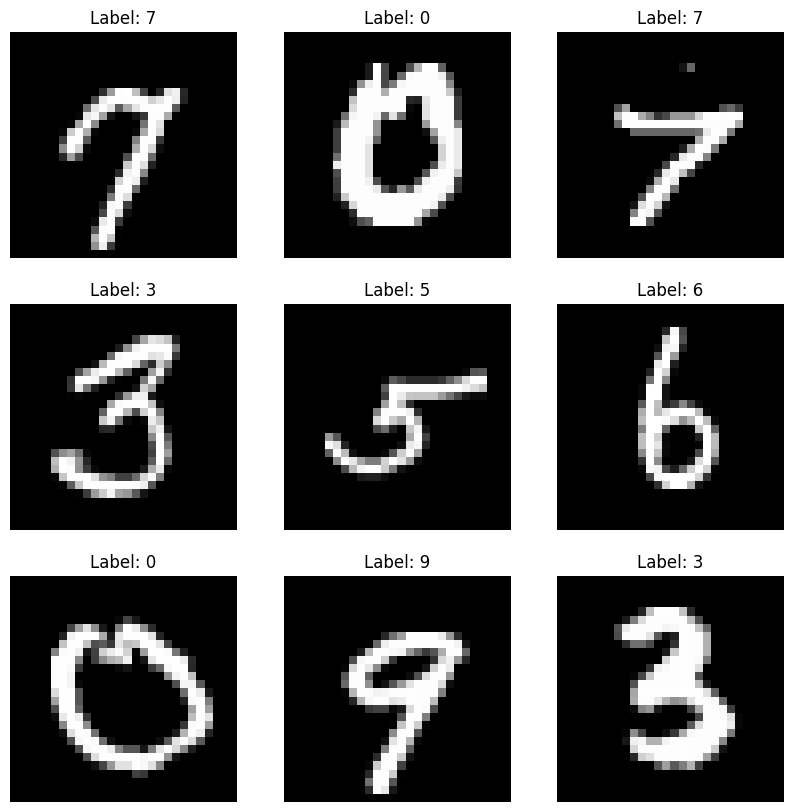

In [ ]:
#Visualize Sample Digits

import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.savefig('sample_digits.png')
plt.show()

In [ ]:
print(images.shape)

torch.Size([64, 1, 28, 28])


In [ ]:
print(len(train_data))

60000


In [ ]:
print(len(test_data))

10000


In [ ]:
#Define CNN Model

import torch.nn as nn

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(32 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10) #10 classes
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(-1, 32 * 7 * 7) #flatting
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = CNN()

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'using device: {device}')

using device: cpu


In [47]:
images, labels = next(iter(train_loader))
images = images.to(device)
output = model(images)
print(output.shape)

torch.Size([64, 10])


In [ ]:
#Train and Evaluate Model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 8
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_loss = test_loss / len(test_loader)
  test_losses.append(test_loss)
  test_accuracy = 100 * correct / total
  test_accuracies.append(test_accuracy)
  print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/8, Train Loss: 0.2430
Epoch 1/8, Test Loss: 0.0640, Test Accuracy: 98.03%
Epoch 2/8, Train Loss: 0.0681
Epoch 2/8, Test Loss: 0.0402, Test Accuracy: 98.66%
Epoch 3/8, Train Loss: 0.0499
Epoch 3/8, Test Loss: 0.0317, Test Accuracy: 98.92%
Epoch 4/8, Train Loss: 0.0403
Epoch 4/8, Test Loss: 0.0326, Test Accuracy: 98.98%
Epoch 5/8, Train Loss: 0.0333
Epoch 5/8, Test Loss: 0.0276, Test Accuracy: 99.14%
Epoch 6/8, Train Loss: 0.0277
Epoch 6/8, Test Loss: 0.0309, Test Accuracy: 99.08%
Epoch 7/8, Train Loss: 0.0241
Epoch 7/8, Test Loss: 0.0289, Test Accuracy: 98.99%
Epoch 8/8, Train Loss: 0.0206
Epoch 8/8, Test Loss: 0.0277, Test Accuracy: 99.06%


In [51]:
torch.save(model.state_dict(), 'mnist_cnn.pth')

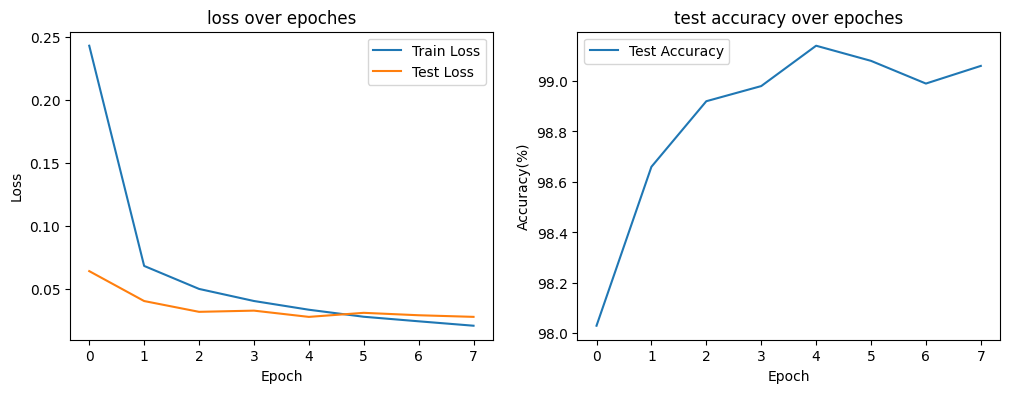

In [ ]:
#Plot Loss and Accuracy

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('loss over epoches')
plt.savefig('loss_plot.png')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.title('test accuracy over epoches')
plt.savefig('accuracy_plot.png')
plt.show()

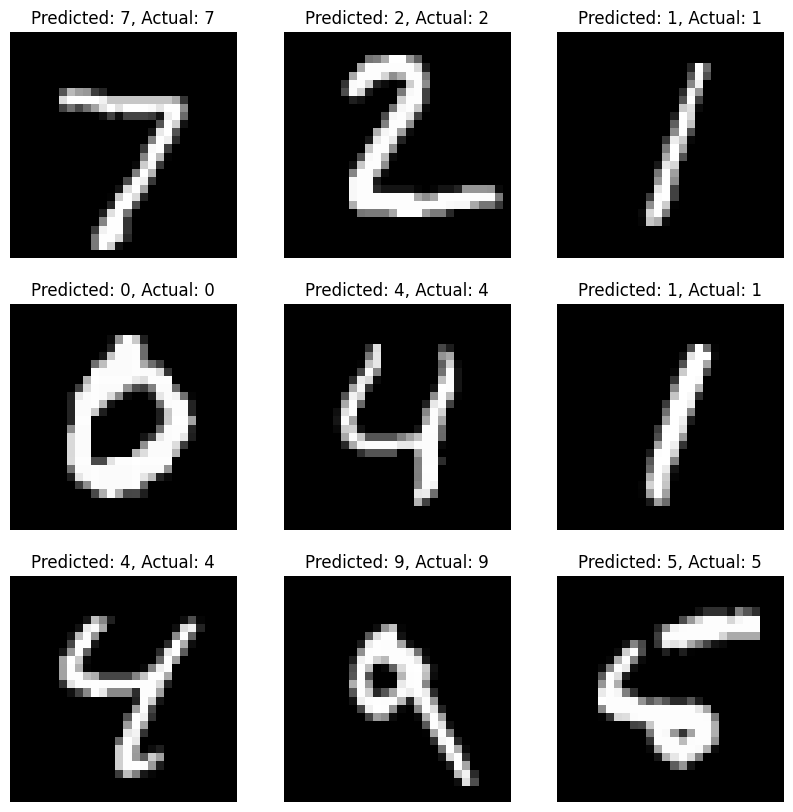

In [ ]:
#Visualize Predictions

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted[i].item()}, Actual: {labels[i].item()}')
    plt.axis('off')
plt.savefig('predictions.png')
plt.show()